In [1]:
# project: p5
# submitter: chen2328
# partner: none
# hours: 15

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import zipfile
import csv
import io
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from edgar_utils import lookup_region, Filing

In [34]:
with zipfile.ZipFile("server_log.zip", "r") as zf:
    with zf.open("rows.csv", "r") as f:
        data = pd.read_csv(f)

### Q1: what's the total size in bytes of the files requested?

In [35]:
#q1
data['size'] = data['size'].apply(pd.to_numeric)
int(sum(data['size']))

24801002666

In [36]:
# data.groupby("ip").size().sort_values(ascending=False)[:10]

### Q2: how many filings have been accessed by the top ten IPs?

In [37]:
#q2
topten_ip = data['ip'].value_counts().sort_values(ascending=False)[:10]
topten_ip.to_dict()

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

### Q3: what fraction of the requests had errors?

In [8]:
#q3
len(data[data['code'] >= 400]) / len(data)

0.03466852724527611

### Q4: what is the most frequently accessed file?

In [9]:
#q4
data['url'] = data['cik'].astype(int).astype(str) + '/'+ data['accession'] + '/' + data['extention']
data['url'].value_counts().index[0]

'1627631/0001627631-15-000004/.txt'

### Q5: how many requests were made by automated crawlers?

In [10]:
#q5
crawler = data['crawler'].value_counts().sort_values(ascending=False)
crawler.to_dict()
crawler[1.0]

971

### Q6: which region uses EDGAR most heavily?

In [11]:
#q6
data['region'] = data['ip'].apply(lookup_region)
data['region'].value_counts().sort_values(ascending=False).index[0]

'United States of America'

### Q7: what fraction of IPs in each region are high-volume users?

In [12]:
total = (data.groupby('ip').size() > 1000)
high_ip = total[total]

In [13]:
total = (data['ip'].value_counts() > 1000)
high = total[total]
high_volumn_series = high.index.to_series().apply(lookup_region)
high_volumn_series.value_counts()


United States of America                                26
Ireland                                                  5
China                                                    3
United Kingdom of Great Britain and Northern Ireland     3
India                                                    2
Korea (Republic of)                                      2
Canada                                                   1
France                                                   1
Bulgaria                                                 1
Australia                                                1
dtype: int64

In [14]:
ip = total.index.to_series().apply(lookup_region)
ip.value_counts()

United States of America                                1309
China                                                    437
France                                                   271
Canada                                                    56
United Kingdom of Great Britain and Northern Ireland      45
                                                        ... 
Greece                                                     1
Honduras                                                   1
Croatia                                                    1
Virgin Islands (British)                                   1
Slovenia                                                   1
Length: 72, dtype: int64

In [15]:
#q7
(high_volumn_series.value_counts() / ip.value_counts()).fillna(0).to_dict()

{'-': 0.0,
 'Algeria': 0.0,
 'Angola': 0.0,
 'Armenia': 0.0,
 'Australia': 0.07692307692307693,
 'Austria': 0.0,
 'Bangladesh': 0.0,
 'Brazil': 0.0,
 'Bulgaria': 0.3333333333333333,
 'Canada': 0.017857142857142856,
 'China': 0.006864988558352402,
 'Croatia': 0.0,
 'Cyprus': 0.0,
 'Czechia': 0.0,
 'Denmark': 0.0,
 'Egypt': 0.0,
 'Estonia': 0.0,
 'Finland': 0.0,
 'France': 0.0036900369003690036,
 'Germany': 0.0,
 'Greece': 0.0,
 'Honduras': 0.0,
 'Hong Kong': 0.0,
 'Hungary': 0.0,
 'India': 0.058823529411764705,
 'Indonesia': 0.0,
 'Iraq': 0.0,
 'Ireland': 0.3125,
 'Israel': 0.0,
 'Italy': 0.0,
 'Japan': 0.0,
 'Jersey': 0.0,
 'Jordan': 0.0,
 'Korea (Republic of)': 0.2,
 'Latvia': 0.0,
 'Lebanon': 0.0,
 'Liberia': 0.0,
 'Luxembourg': 0.0,
 'Malaysia': 0.0,
 'Mexico': 0.0,
 'Mongolia': 0.0,
 'Morocco': 0.0,
 'Netherlands': 0.0,
 'Nigeria': 0.0,
 'North Macedonia': 0.0,
 'Pakistan': 0.0,
 'Philippines': 0.0,
 'Poland': 0.0,
 'Portugal': 0.0,
 'Romania': 0.0,
 'Russian Federation': 0.0,
 'Sa

### Q8: what dates appear in the 850693/0000850693-07-000159/-index.htm file of docs.zip?

In [16]:
filing_dict = {}
with zipfile.ZipFile("docs.zip", "r") as zf:
       for name in zf.namelist():
            if '.htm' in name or '.html' in name:
                with zf.open(name, "r") as f:
                    file = f.read()
                    file = str(file, encoding='utf-8')
                    value = Filing(file)
                    filing_dict[name] = value

In [17]:
#q8
filing_dict['850693/0000850693-07-000159/-index.htm'].dates

['2007-07-25', '2007-07-25', '2007-07-23']

### Q9: what is the distribution of states for the filings in docs.zip?

In [18]:
#q9
state_dict = {}
for key, value in filing_dict.items():
    abb_code = value.state()
    if abb_code:
        if abb_code not in state_dict:
            state_dict[abb_code] = 1
        else:
            state_dict[abb_code] += 1

number_state = pd.Series(state_dict)
number_state.sort_values(ascending=False).to_dict()

{'CA': 91,
 'NY': 83,
 'TX': 64,
 'MA': 30,
 'PA': 25,
 'IL': 25,
 'CO': 25,
 'NJ': 23,
 'FL': 21,
 'MN': 15,
 'VA': 15,
 'CT': 14,
 'MD': 13,
 'MI': 11,
 'OH': 10,
 'DE': 10,
 'WI': 9,
 'NC': 9,
 'GA': 8,
 'OK': 7,
 'NV': 6,
 'IA': 6,
 'OX': 6,
 'AZ': 5,
 'KS': 5,
 'UT': 5,
 'TN': 4,
 'MO': 4,
 'IN': 4,
 'WA': 3,
 'WV': 2,
 'OR': 2,
 'LA': 2,
 'NE': 2,
 'KY': 2,
 'AL': 1,
 'SD': 1,
 'MS': 1,
 'VT': 1,
 'ID': 1,
 'AR': 1,
 'NM': 1,
 'DC': 1,
 'ME': 1}

### Q10: what is the distribution of SIC codes for the filings in docs.zip?

In [19]:
#q10
sic_dict = {}
for key, value in filing_dict.items():
    sic = value.sic
    if sic:
        if sic not in sic_dict:
            sic_dict[sic] = 1
        else:
            sic_dict[sic] += 1

number_sic = pd.Series(sic_dict)
number_sic.sort_values(ascending=False).to_dict()

{2834: 40,
 6021: 20,
 6798: 20,
 6022: 20,
 1311: 20,
 1389: 19,
 6211: 17,
 6189: 17,
 2836: 13,
 7389: 11,
 7372: 11,
 6029: 11,
 1000: 11,
 6331: 10,
 4911: 8,
 6282: 8,
 6199: 8,
 2860: 8,
 7370: 7,
 3841: 6,
 7371: 6,
 3674: 5,
 900: 5,
 4931: 5,
 3826: 5,
 4522: 5,
 1700: 5,
 8742: 5,
 6035: 4,
 4813: 4,
 3842: 4,
 2510: 4,
 3663: 4,
 7374: 4,
 5812: 4,
 3420: 3,
 6799: 3,
 3510: 3,
 8062: 3,
 1400: 3,
 3829: 3,
 2800: 3,
 7200: 3,
 7373: 3,
 6221: 3,
 3576: 3,
 3620: 3,
 3845: 2,
 2810: 2,
 1382: 2,
 4512: 2,
 7812: 2,
 3690: 2,
 3679: 2,
 5661: 2,
 7900: 2,
 5065: 2,
 4812: 2,
 3621: 2,
 5122: 2,
 3661: 2,
 3577: 2,
 1040: 2,
 2870: 2,
 1531: 2,
 6141: 2,
 3272: 2,
 3695: 2,
 3825: 2,
 2111: 2,
 8731: 2,
 3559: 2,
 5172: 2,
 4922: 2,
 4841: 2,
 5500: 2,
 1731: 2,
 6324: 2,
 6321: 2,
 8082: 2,
 5940: 2,
 3990: 2,
 5900: 2,
 7830: 2,
 6311: 2,
 3669: 2,
 1221: 2,
 8711: 2,
 5030: 1,
 6792: 1,
 5961: 1,
 3827: 1,
 1381: 1,
 2780: 1,
 3443: 1,
 3630: 1,
 5990: 1,
 8200: 1,
 7990: 

## Part 4: combining logs with documents
### Q11: what is the distribution of requests across industries?

In [20]:
#q11
logs_lst = data['url'].to_list()
sic_dict = defaultdict(int)
for file in logs_lst:
    if file in filing_dict:
        file_obj = filing_dict[file]
        sic = file_obj.sic
        if sic:
            sic_dict[sic] += 1

sic_series = pd.Series(sic_dict)
#sic_series.sort_values(ascending=False)[:10].to_dict()
sic_series.sort_values(ascending=False).to_dict()

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 2510: 171,
 6282: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 5311: 90,
 6798: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 900: 39,
 7370: 39,
 3621: 38,
 6513: 38,
 5172: 36,
 4213: 35,
 5900: 35,
 3990: 34,
 5122: 34,
 2070: 33,
 5944: 33,
 8090: 32,
 1700: 31,
 4922: 31,
 3312: 31,
 1381: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 3663: 23,
 4955: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 6792: 19,
 5812: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 6035: 7,
 4833: 7,
 2430: 6,
 3571: 6,
 3674: 5,
 3679: 5,
 4813: 4,
 4812: 4,
 3678: 4,
 5500: 4,
 1531: 4,
 6411: 3,
 3576: 3,
 8062: 3,
 2800: 3,
 3420: 3,
 1400: 3,
 2111: 2,
 7900: 2,
 5661: 2,
 6141: 

### Q12: how many requests were made in each hour?

In [21]:
#q12
data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour
data.groupby('hour').size().to_dict()

{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

### Q13: what is the geographic overlap in interest between Australia, France, and Viet Nam?

In [22]:
from graphviz import Digraph, Graph

In [23]:
g = Digraph()

In [24]:
q13_table = data.loc[(data['region'] == 'Australia') | (data['region'] == 'France') | (data['region'] == 'Viet Nam')]
q13_table = q13_table.sort_values(by=['region'])

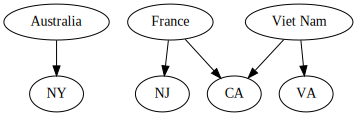

In [25]:
#q13

match_dict = {}
for i in range(len(q13_table)):
    if q13_table['url'].iloc[i] in filing_dict:
        country = q13_table['region'].iloc[i]
        file = q13_table['url'].iloc[i]
        state = filing_dict[file].state()
        # if have the edge between those two, don't add
        if country in match_dict and state in match_dict[country]:
            pass
        else:
            g.node(country)
            g.node(state)
            g.edge(country, state)
            # add new country to the dict
            if len(match_dict) == 0 or country not in match_dict:
                match_dict[country] = [state]
            # append state code to country already in dict
            if len(match_dict[country]) > 0:
                match_dict[country].append(state)

g

### Q14: what are the most commonly seen street addresses?

In [26]:
#q14
add_dict = defaultdict(int)
for log in logs_lst:
    if log in filing_dict:
        obj = filing_dict[log]
        addresses = obj.addresses
        for add in addresses:
            add_dict[add] += 1 

add_series = pd.Series(add_dict).sort_values(ascending=False)
add_series[add_series >= 225].to_dict()

{'801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 720,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102\n817-334-4100': 464,
 '1114 AVENUE OF THE AMERICAS\n29TH FLOOR\nNEW YORK NY 10036': 356,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104': 305,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383': 289,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383\n425-442-0931': 289,
 '1881 GROVE AVENUE\nRADFORD VA 24141': 277,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104\n3125066500': 264,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020\n212-956-2221': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3\n604-683-6332': 225}

### Q15: geographic plotting of headquarters

In [27]:
import geopandas as gpd
from shapely.geometry import Polygon, box, Point

In [28]:
us_df = gpd.read_file("shapes/cb_2018_us_state_20m.shp")

In [29]:
us_window = box(-130, 20, -55, 50)
#us_window = box(-130, -55, 20, 50)
us = us_df.intersection(us_window)
us = us[~us.is_empty]
us = us.to_crs("epsg:3395")

In [30]:
add_df = gpd.read_file('locations.geojson').to_crs(us.crs)

In [31]:
add_df['frequency_of_requests'] = add_df['address'].map(add_dict)

In [32]:
add_df.head()

,address,geometry,frequency_of_requests
0,245 SUMMER STREET\nBOSTON MA 02210,POINT (-7909666.216 5184949.861),6
1,100 PINE STREET\nSUITE 2800\nSAN FRANCISCO CA ...,POINT (-13625396.803 4523993.966),1
2,1401 17TH STREET\nSUITE 1000\nDENVER CO 80202,POINT (-11688221.447 4802519.965),93
3,10550 TALBERT AVENUE\nFOUNTAIN VALLEY CA 92708,POINT (-13129225.770 3964944.976),1
4,388 GREENWICH ST\n38TH FLOOR\nNEW YORK NY 10013,POINT (-8238885.993 4943342.642),19


<AxesSubplot:>

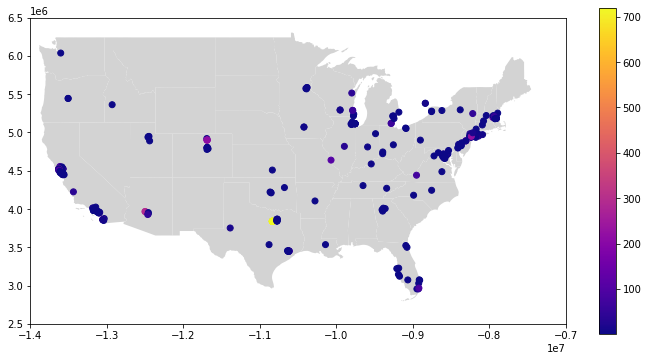

In [33]:
#q15
ax = us.plot(color="lightgray", figsize=(12,6))
ax.set_xlim((-1.4*1e7, -0.7*1e7))
ax.set_ylim((2.5*1e6, 6.5*1e6))
add_df.plot(column='frequency_of_requests', cmap='plasma', legend=True, ax=ax)
